## Convolutional Neural Network 

#### For classifying audio data in the UrbanSound8K dataset.

In this Notebook we create a Covolutional Neural Network to classify audio data. 

In [2]:
import json
import random
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow
import tensorflow.keras as keras
from keras.regularizers import l2
from sklearn.model_selection import KFold


## Load the Data

First, we need to load our data. We are going to use MFFC with nffc = 40 to train and test our model.

In [3]:
#Deve atualizar a sua localização em relação ao ficheiro
data = pd.read_json("/content/drive/MyDrive/files/features40.json")

In [4]:
data

,file,salience,fold,mfcc40,classID
0,135776-2-0-49.wav,2,1,"[[0.1043594405, 0.0525185205, 0.0584450252, 0....",2
1,46654-6-0-0.wav,1,1,"[[0.0, 0.026401408, 0.026924215300000002, 0.30...",6
2,57320-0-0-24.wav,2,1,"[[0.2571681142, 0.19033260640000002, 0.1936520...",0
3,134717-0-0-26.wav,1,1,"[[0.1350698918, 0.0285070594, 0.0413862392, 0....",0
4,174276-7-5-0.wav,1,1,"[[0.10389473290000001, 0.2066275626, 0.1831817...",7
...,...,...,...,...,...
8727,88121-8-0-0.wav,2,10,"[[0.0431582965, 0.031919945000000005, 0.038528...",8
8728,189982-0-0-42.wav,1,10,"[[0.0, 0.055268406900000004, 0.047489263100000...",0
8729,74364-8-1-7.wav,2,10,"[[0.033702936, 0.080786258, 0.1064587533, 0.09...",8
8730,99192-4-0-7.wav,1,10,"[[0.1716143936, 0.31627538800000005, 0.2538642...",4


The corresponding labels to classID:

In [3]:
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

We know that most of the MFCC's we have have the shape (40, 321), but there are some with different shapes, in particular with a different number of columns. The following function finds those elements:

In [6]:
def dif_shape(df, rep, shape):
    list = []
    for i in range(len(df)):
        m = df.loc[i][rep]
        n = np.array(m)
        if(n.shape != shape):
            list.append(i)
    return list

# len(dif_shape(data, 'mfcc40', (40,321)))

After identifying the MFCC's with different shapes, we have 2 options: remove them from our dataset or reshape them to fit (40,321). Because there are only 7 (all from class 2) different elements, we decided to remove them.

In [7]:
list = dif_shape(data, 'mfcc40', (40,321))
data1 = data.drop(list)
data1

,file,salience,fold,mfcc40,classID
0,135776-2-0-49.wav,2,1,"[[0.1043594405, 0.0525185205, 0.0584450252, 0....",2
1,46654-6-0-0.wav,1,1,"[[0.0, 0.026401408, 0.026924215300000002, 0.30...",6
2,57320-0-0-24.wav,2,1,"[[0.2571681142, 0.19033260640000002, 0.1936520...",0
3,134717-0-0-26.wav,1,1,"[[0.1350698918, 0.0285070594, 0.0413862392, 0....",0
4,174276-7-5-0.wav,1,1,"[[0.10389473290000001, 0.2066275626, 0.1831817...",7
...,...,...,...,...,...
8727,88121-8-0-0.wav,2,10,"[[0.0431582965, 0.031919945000000005, 0.038528...",8
8728,189982-0-0-42.wav,1,10,"[[0.0, 0.055268406900000004, 0.047489263100000...",0
8729,74364-8-1-7.wav,2,10,"[[0.033702936, 0.080786258, 0.1064587533, 0.09...",8
8730,99192-4-0-7.wav,1,10,"[[0.1716143936, 0.31627538800000005, 0.2538642...",4


## Split the Data

Next step is spliting the data into train, validate and test sets. As it is explained in the UrbanSound dataset website, it is best to use the predefined 10 folds and perform 10-fold cross validation. 

In this first phase of trying to create our model we use the data in folders 1 to 8 to train our model, folder 9 for validation and folder 10 for testing. When we have our final model, we will do the full 10-cross validation.

In [15]:
def to_array(list):
    new_list = []
    for m in list:
        m1 = np.array(m)
        new_list.append(m1)
    array = np.array(new_list)
    return array

def split_data(representation, df, test_fold):
    #dividir folds
    folds = [1,2,3,4,5,6,7,8,9,10]

    test_fold = test_fold
    folds.remove(test_fold)
    validation_fold = random.choice(folds)
    folds.remove(validation_fold)
    train_folds = folds

    #separar dataframe df de acordo com os folds resultantes
    test_data = df[df['fold'] == test_fold]
    train_data = df[df['fold'].isin(train_folds)]
    validation_data = df[df['fold'] == validation_fold]

    # Separar as features e os labels
    x_train = train_data[representation].values
    X_train = to_array(x_train)
    y_train = train_data['classID'].values

    x_validation = validation_data[representation].values
    X_validation = to_array(x_validation)
    y_validation = validation_data['classID'].values

    x_test = test_data[representation].values
    X_test = to_array(x_test)
    y_test = test_data['classID'].values

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [17]:
# get train, validation, test splits
X_train, y_train, X_validation, y_validation, X_test, y_test = split_data('mfcc40', data1, 9)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)

## Build Model

Defining a function that will help visualize how the model is performing:

In [18]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

Now we start to experiment on the architecture of the model.
First, we tried a simple model with just one convolutional block, a flatenning layer and a dense layer with 10 neurons and softmax activation. The convolutional block has the following structure:

**1.** ConvolutionalLayer, with 32 (or 64) filters, each with size 3x3 and ReLU as an activation function.

**2.** MaxPooling, with pool_size = 2x2 and strides = 2x2

**3.** BatchNormalization

The results were weak and showed overfitting as expected. We then proceeded to add another convolutional block to the model and a dense layer with 32 neurons, but still the model wasn't learning much.

Next step was experimenting with regularization to help the overfitting problem. First we just added a **Dropout** layer and tested; we didn't see much change so we kept on trying other regularization methods, like **L2 regularization**. The L2 regularizer was added to the convolutional layers with strength = 0.01, and it seemed to be effective.

But still, continued to overfit so our last changes were adding Spatial Dropout and another layer of Max Pooling to reduce the number of parameters, and to see if the model would generalize better.

Throughout this process we were training our models with batch size = 32 and epochs = 30, just to check the models behaviour. We then saw that the batch size was too small and it was causing some variance between epochs, so we tried with 64 and 100. 100 batch size gave us the better results, as we saw fewer variance and it didn't take very long to train the model. When we started to see better results with our models, we started augmenting the size of epochs have a better knowledge of how it was performing in the long run.

After tweaking some values, this was our final model.

In [19]:
def build_model(input_shape):
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32, (3, 3),kernel_regularizer=l2(0.01), input_shape=input_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.SpatialDropout2D(0.1))

    model.add(keras.layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.01)))
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.SpatialDropout2D(0.2))

    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [20]:
# create network
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 319, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 38, 319, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 160, 32)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 19, 160, 32)       128       
 Normalization)                                                  
                                                                 
 spatial_dropout2d (Spatial  (None, 19, 160, 32)       0         
 Dropout2D)                                                      
                                                        

Epoch 1/100
70/70 [==============================] - 14s 28ms/step - loss: 3.9617 - accuracy: 0.2224 - val_loss: 3.9686 - val_accuracy: 0.1122
Epoch 2/100
70/70 [==============================] - 1s 20ms/step - loss: 3.6070 - accuracy: 0.3014 - val_loss: 4.0166 - val_accuracy: 0.2244
Epoch 3/100
70/70 [==============================] - 1s 20ms/step - loss: 3.4010 - accuracy: 0.3516 - val_loss: 4.0233 - val_accuracy: 0.2212
Epoch 4/100
70/70 [==============================] - 1s 20ms/step - loss: 3.2448 - accuracy: 0.3904 - val_loss: 4.2598 - val_accuracy: 0.1667
Epoch 5/100
70/70 [==============================] - 1s 20ms/step - loss: 3.0916 - accuracy: 0.4142 - val_loss: 3.9469 - val_accuracy: 0.2382
Epoch 6/100
70/70 [==============================] - 1s 20ms/step - loss: 2.9429 - accuracy: 0.4486 - val_loss: 3.5841 - val_accuracy: 0.3056
Epoch 7/100
70/70 [==============================] - 1s 20ms/step - loss: 2.8199 - accuracy: 0.4730 - val_loss: 3.3005 - val_accuracy: 0.3194
Epoch

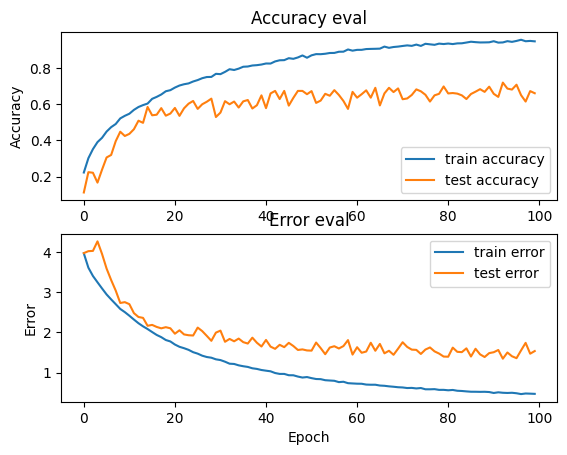

In [21]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=100, epochs=100)

# plot accuracy/error for training and validation
plot_history(history)

In [22]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTest accuracy:', test_acc)
print('\nTest accuracy:', test_loss)


Test accuracy: 0.6715686321258545

Test accuracy: 1.6972649097442627


### Confusion Matrix

In [23]:
def confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis =1)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
    cm_display.plot(xticks_rotation='vertical')
    plt.show()
    return y_pred, confusion_matrix

26/26 [==============================] - 0s 3ms/step


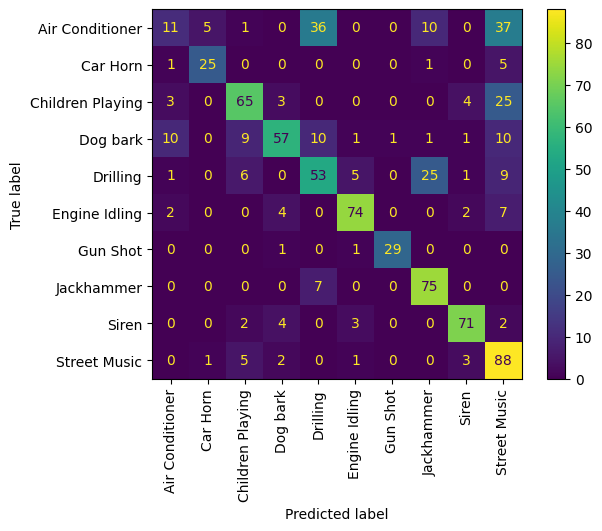

In [24]:
y_pred, cm = confusion_matrix(model, X_test, y_test)

### Report

In [25]:
report = classification_report(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(report)

                  precision    recall  f1-score   support

 Air Conditioner       0.39      0.11      0.17       100
        Car Horn       0.81      0.78      0.79        32
Children Playing       0.74      0.65      0.69       100
        Dog bark       0.80      0.57      0.67       100
        Drilling       0.50      0.53      0.51       100
   Engine Idling       0.87      0.83      0.85        89
        Gun Shot       0.97      0.94      0.95        31
      Jackhammer       0.67      0.91      0.77        82
           Siren       0.87      0.87      0.87        82
    Street Music       0.48      0.88      0.62       100

        accuracy                           0.67       816
       macro avg       0.71      0.71      0.69       816
    weighted avg       0.67      0.67      0.65       816



## Using All Folds

Since we have our final model, it's time to test how it performs in the entire dataset.

In [ ]:
# This function gives the accuracy per class
def acc_per_class(conf_matrix):
    total_samples_per_class = np.sum(conf_matrix, axis=1)
    correct_predictions_per_class = np.diag(conf_matrix)
    accuracies = correct_predictions_per_class / total_samples_per_class
    return accuracies

The next functions were created to train and test our model in 10 iterations and save the respective metrics. Here we train with 60 epochs and with 100 batch size:

In [ ]:
def save(dic,tl,tc,yp,re,cm,i):
    dic[f"loss{i}"] = tl
    dic[f"acc{i}"] = tc
    dic[f"pred{i}"] = yp
    dic[f"report{i}"] = re
    dic[f"confusion_matrix{i}"] = cm
    
def ten_fold_cross_validation(df,representation):
    input_shape = (40,321,1)
    dictionary = {}

    for i in range(1,11):
        X_train, y_train, X_valid, y_valid, X_test, y_test = split_data_cross_validation('mfcc40', df, i)
        #Build and compile the model
        model = build_model(input_shape)
        optimiser = keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=60, batch_size=100)

        #Evaluate and save model statistics
        test_loss, test_acc = model.evaluate(X_test, y_test)
        y_pred, cm = confusion_matrix(model, X_test, y_test)
        report = classification_report(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

        save(dictionary, test_loss, test_acc, y_pred, report, cm, i)

    return dictionary

Epoch 1/60
71/71 [==============================] - 3s 23ms/step - loss: 4.0057 - accuracy: 0.1997 - val_loss: 3.9439 - val_accuracy: 0.1215
Epoch 2/60
71/71 [==============================] - 1s 19ms/step - loss: 3.5972 - accuracy: 0.2877 - val_loss: 3.9459 - val_accuracy: 0.1215
Epoch 3/60
71/71 [==============================] - 1s 19ms/step - loss: 3.3907 - accuracy: 0.3471 - val_loss: 3.8848 - val_accuracy: 0.1276
Epoch 4/60
71/71 [==============================] - 1s 20ms/step - loss: 3.1972 - accuracy: 0.3932 - val_loss: 3.7070 - val_accuracy: 0.2041
Epoch 5/60
71/71 [==============================] - 1s 20ms/step - loss: 3.0521 - accuracy: 0.4261 - val_loss: 3.5130 - val_accuracy: 0.2029
Epoch 6/60
71/71 [==============================] - 1s 19ms/step - loss: 2.9110 - accuracy: 0.4594 - val_loss: 3.1485 - val_accuracy: 0.3305
Epoch 7/60
71/71 [==============================] - 1s 19ms/step - loss: 2.7695 - accuracy: 0.4831 - val_loss: 2.9894 - val_accuracy: 0.3949
Epoch 8/60
71

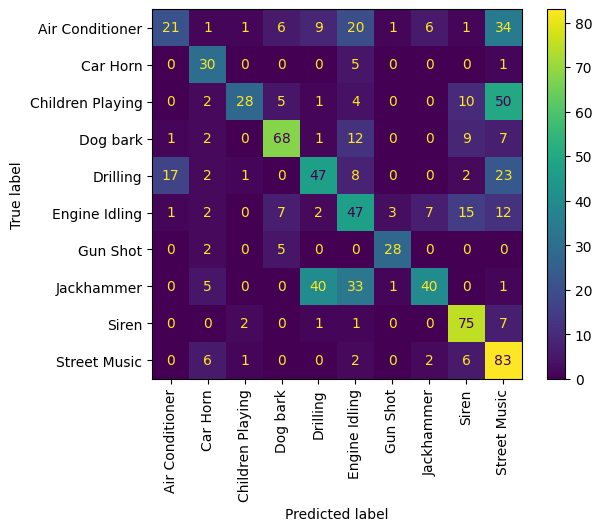

Epoch 1/60
71/71 [==============================] - 3s 24ms/step - loss: 3.9359 - accuracy: 0.2364 - val_loss: 3.9593 - val_accuracy: 0.1225
Epoch 2/60
71/71 [==============================] - 1s 19ms/step - loss: 3.5910 - accuracy: 0.3098 - val_loss: 3.9428 - val_accuracy: 0.1225
Epoch 3/60
71/71 [==============================] - 1s 19ms/step - loss: 3.4091 - accuracy: 0.3556 - val_loss: 3.9776 - val_accuracy: 0.1225
Epoch 4/60
71/71 [==============================] - 1s 19ms/step - loss: 3.2263 - accuracy: 0.4018 - val_loss: 4.1011 - val_accuracy: 0.1225
Epoch 5/60
71/71 [==============================] - 1s 19ms/step - loss: 3.0912 - accuracy: 0.4318 - val_loss: 4.0964 - val_accuracy: 0.1311
Epoch 6/60
71/71 [==============================] - 1s 19ms/step - loss: 2.9603 - accuracy: 0.4610 - val_loss: 3.7496 - val_accuracy: 0.1961
Epoch 7/60
71/71 [==============================] - 1s 19ms/step - loss: 2.8298 - accuracy: 0.4807 - val_loss: 3.4327 - val_accuracy: 0.2169
Epoch 8/60
71

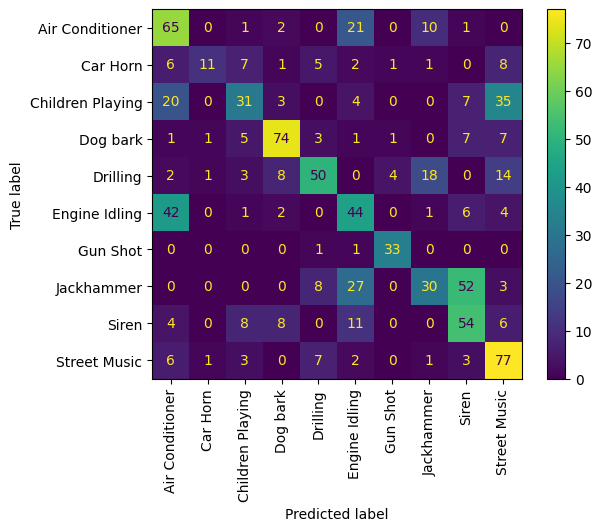

Epoch 1/60
70/70 [==============================] - 3s 25ms/step - loss: 3.9614 - accuracy: 0.2276 - val_loss: 3.9776 - val_accuracy: 0.1159
Epoch 2/60
70/70 [==============================] - 1s 19ms/step - loss: 3.6095 - accuracy: 0.2921 - val_loss: 3.9990 - val_accuracy: 0.1278
Epoch 3/60
70/70 [==============================] - 1s 19ms/step - loss: 3.4354 - accuracy: 0.3297 - val_loss: 4.2676 - val_accuracy: 0.1231
Epoch 4/60
70/70 [==============================] - 1s 19ms/step - loss: 3.2528 - accuracy: 0.3879 - val_loss: 4.5029 - val_accuracy: 0.1434
Epoch 5/60
70/70 [==============================] - 1s 19ms/step - loss: 3.0941 - accuracy: 0.4194 - val_loss: 4.2843 - val_accuracy: 0.1470
Epoch 6/60
70/70 [==============================] - 1s 19ms/step - loss: 2.9583 - accuracy: 0.4481 - val_loss: 3.9083 - val_accuracy: 0.2103
Epoch 7/60
70/70 [==============================] - 1s 19ms/step - loss: 2.8469 - accuracy: 0.4670 - val_loss: 3.2515 - val_accuracy: 0.3011
Epoch 8/60
70

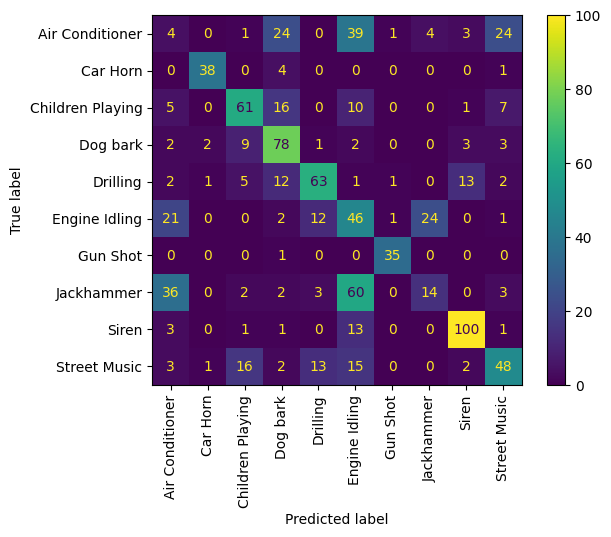

Epoch 1/60
69/69 [==============================] - 3s 25ms/step - loss: 3.9602 - accuracy: 0.2281 - val_loss: 4.0216 - val_accuracy: 0.1126
Epoch 2/60
69/69 [==============================] - 1s 19ms/step - loss: 3.5707 - accuracy: 0.3057 - val_loss: 4.5986 - val_accuracy: 0.1126
Epoch 3/60
69/69 [==============================] - 1s 19ms/step - loss: 3.3865 - accuracy: 0.3550 - val_loss: 5.2302 - val_accuracy: 0.1126
Epoch 4/60
69/69 [==============================] - 1s 19ms/step - loss: 3.2248 - accuracy: 0.4031 - val_loss: 5.5298 - val_accuracy: 0.1126
Epoch 5/60
69/69 [==============================] - 1s 19ms/step - loss: 3.1008 - accuracy: 0.4196 - val_loss: 5.2449 - val_accuracy: 0.1126
Epoch 6/60
69/69 [==============================] - 1s 19ms/step - loss: 2.9695 - accuracy: 0.4450 - val_loss: 4.6275 - val_accuracy: 0.1171
Epoch 7/60
69/69 [==============================] - 1s 20ms/step - loss: 2.8563 - accuracy: 0.4595 - val_loss: 3.9290 - val_accuracy: 0.1599
Epoch 8/60
69

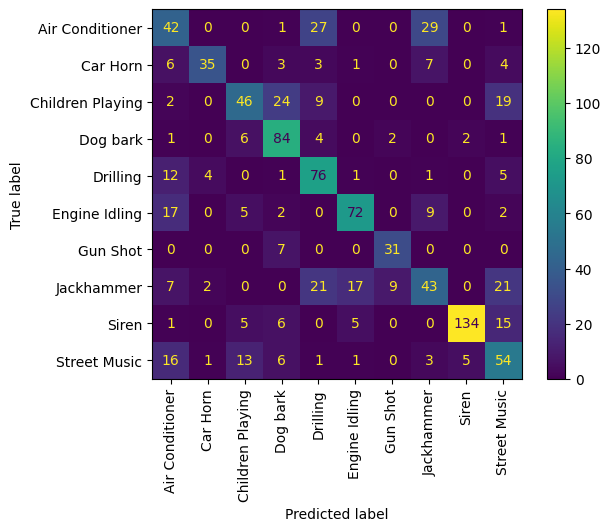

Epoch 1/60
70/70 [==============================] - 3s 25ms/step - loss: 3.9006 - accuracy: 0.2380 - val_loss: 3.9495 - val_accuracy: 0.1193
Epoch 2/60
70/70 [==============================] - 1s 20ms/step - loss: 3.5033 - accuracy: 0.3371 - val_loss: 3.9766 - val_accuracy: 0.1193
Epoch 3/60
70/70 [==============================] - 1s 20ms/step - loss: 3.3145 - accuracy: 0.3785 - val_loss: 4.0723 - val_accuracy: 0.1193
Epoch 4/60
70/70 [==============================] - 1s 19ms/step - loss: 3.1419 - accuracy: 0.4230 - val_loss: 4.2513 - val_accuracy: 0.1253
Epoch 5/60
70/70 [==============================] - 1s 19ms/step - loss: 3.0006 - accuracy: 0.4548 - val_loss: 4.0685 - val_accuracy: 0.1372
Epoch 6/60
70/70 [==============================] - 1s 19ms/step - loss: 2.8902 - accuracy: 0.4748 - val_loss: 3.6554 - val_accuracy: 0.2053
Epoch 7/60
70/70 [==============================] - 1s 19ms/step - loss: 2.7450 - accuracy: 0.5017 - val_loss: 3.2726 - val_accuracy: 0.3186
Epoch 8/60
70

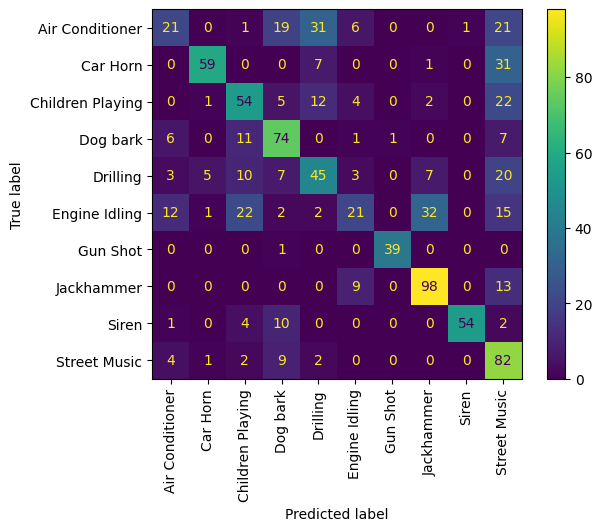

Epoch 1/60
70/70 [==============================] - 3s 26ms/step - loss: 3.9510 - accuracy: 0.2240 - val_loss: 3.9680 - val_accuracy: 0.1373
Epoch 2/60
70/70 [==============================] - 1s 20ms/step - loss: 3.5453 - accuracy: 0.3120 - val_loss: 3.9814 - val_accuracy: 0.1686
Epoch 3/60
70/70 [==============================] - 1s 20ms/step - loss: 3.3394 - accuracy: 0.3742 - val_loss: 3.9978 - val_accuracy: 0.1114
Epoch 4/60
70/70 [==============================] - 1s 19ms/step - loss: 3.1780 - accuracy: 0.4098 - val_loss: 3.9522 - val_accuracy: 0.1146
Epoch 5/60
70/70 [==============================] - 1s 19ms/step - loss: 3.0409 - accuracy: 0.4380 - val_loss: 3.8707 - val_accuracy: 0.1665
Epoch 6/60
70/70 [==============================] - 1s 20ms/step - loss: 2.8801 - accuracy: 0.4789 - val_loss: 3.7854 - val_accuracy: 0.1546
Epoch 7/60
70/70 [==============================] - 1s 20ms/step - loss: 2.7589 - accuracy: 0.4998 - val_loss: 3.4531 - val_accuracy: 0.2119
Epoch 8/60
70

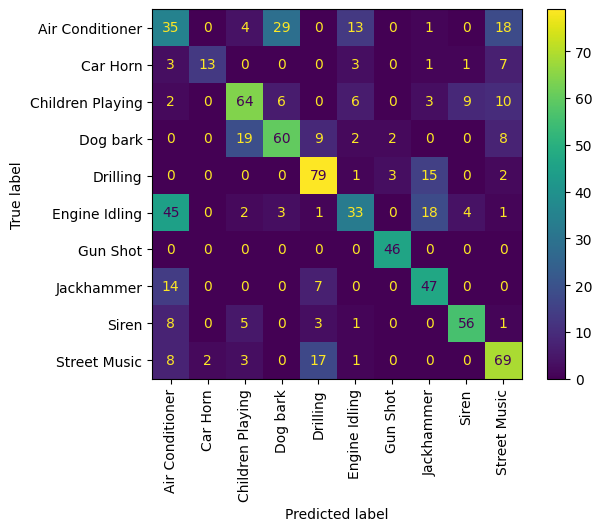

Epoch 1/60
69/69 [==============================] - 3s 26ms/step - loss: 3.9587 - accuracy: 0.2198 - val_loss: 4.0859 - val_accuracy: 0.0596
Epoch 2/60
69/69 [==============================] - 1s 20ms/step - loss: 3.5738 - accuracy: 0.3169 - val_loss: 4.2654 - val_accuracy: 0.0596
Epoch 3/60
69/69 [==============================] - 1s 20ms/step - loss: 3.3730 - accuracy: 0.3686 - val_loss: 4.5596 - val_accuracy: 0.0596
Epoch 4/60
69/69 [==============================] - 1s 20ms/step - loss: 3.2001 - accuracy: 0.4045 - val_loss: 4.8548 - val_accuracy: 0.0596
Epoch 5/60
69/69 [==============================] - 1s 20ms/step - loss: 3.0389 - accuracy: 0.4438 - val_loss: 4.9598 - val_accuracy: 0.0616
Epoch 6/60
69/69 [==============================] - 1s 20ms/step - loss: 2.9216 - accuracy: 0.4637 - val_loss: 4.0242 - val_accuracy: 0.1424
Epoch 7/60
69/69 [==============================] - 1s 20ms/step - loss: 2.8186 - accuracy: 0.4785 - val_loss: 3.4303 - val_accuracy: 0.2212
Epoch 8/60
69

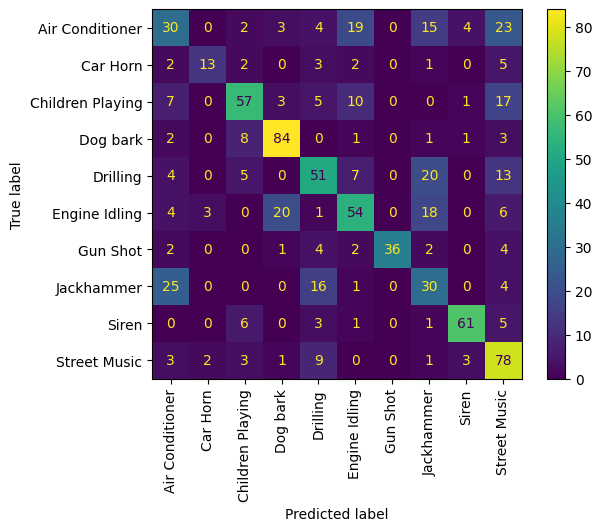

Epoch 1/60
71/71 [==============================] - 4s 26ms/step - loss: 4.0010 - accuracy: 0.1884 - val_loss: 3.9541 - val_accuracy: 0.1077
Epoch 2/60
71/71 [==============================] - 1s 19ms/step - loss: 3.6648 - accuracy: 0.2755 - val_loss: 3.8667 - val_accuracy: 0.1145
Epoch 3/60
71/71 [==============================] - 1s 19ms/step - loss: 3.4763 - accuracy: 0.3190 - val_loss: 3.7187 - val_accuracy: 0.2234
Epoch 4/60
71/71 [==============================] - 1s 19ms/step - loss: 3.2986 - accuracy: 0.3623 - val_loss: 3.6485 - val_accuracy: 0.2176
Epoch 5/60
71/71 [==============================] - 1s 19ms/step - loss: 3.1422 - accuracy: 0.3977 - val_loss: 3.5149 - val_accuracy: 0.1959
Epoch 6/60
71/71 [==============================] - 1s 19ms/step - loss: 2.9982 - accuracy: 0.4235 - val_loss: 3.3794 - val_accuracy: 0.2806
Epoch 7/60
71/71 [==============================] - 1s 19ms/step - loss: 2.8659 - accuracy: 0.4524 - val_loss: 3.2813 - val_accuracy: 0.3173
Epoch 8/60
71

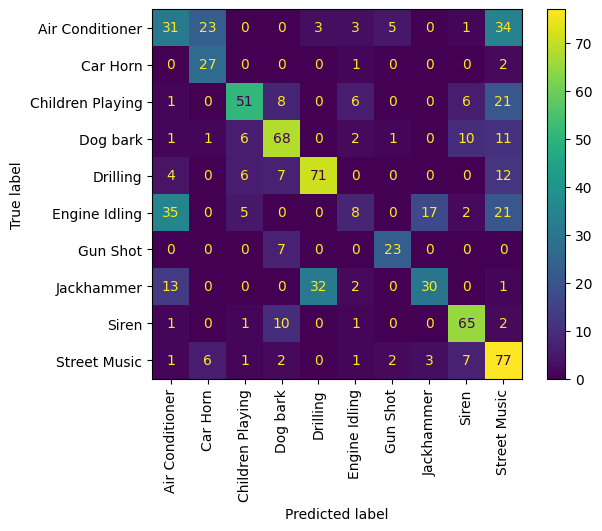

Epoch 1/60
70/70 [==============================] - 3s 24ms/step - loss: 4.0058 - accuracy: 0.2065 - val_loss: 4.0624 - val_accuracy: 0.1010
Epoch 2/60
70/70 [==============================] - 1s 20ms/step - loss: 3.6111 - accuracy: 0.3055 - val_loss: 4.3359 - val_accuracy: 0.1182
Epoch 3/60
70/70 [==============================] - 1s 20ms/step - loss: 3.3908 - accuracy: 0.3545 - val_loss: 4.6500 - val_accuracy: 0.1020
Epoch 4/60
70/70 [==============================] - 1s 20ms/step - loss: 3.2380 - accuracy: 0.3866 - val_loss: 4.8020 - val_accuracy: 0.1768
Epoch 5/60
70/70 [==============================] - 1s 20ms/step - loss: 3.0913 - accuracy: 0.4236 - val_loss: 4.4976 - val_accuracy: 0.2273
Epoch 6/60
70/70 [==============================] - 1s 19ms/step - loss: 2.9683 - accuracy: 0.4466 - val_loss: 4.2135 - val_accuracy: 0.1929
Epoch 7/60
70/70 [==============================] - 1s 19ms/step - loss: 2.8318 - accuracy: 0.4635 - val_loss: 3.5984 - val_accuracy: 0.2455
Epoch 8/60
70

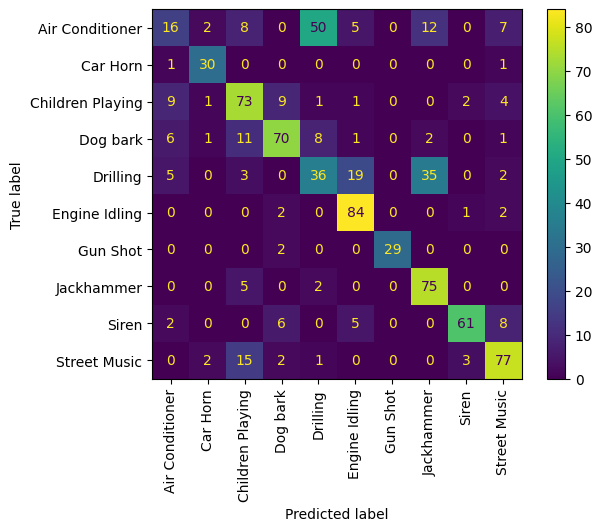

Epoch 1/60
70/70 [==============================] - 3s 23ms/step - loss: 3.9720 - accuracy: 0.2220 - val_loss: 3.9618 - val_accuracy: 0.1611
Epoch 2/60
70/70 [==============================] - 1s 19ms/step - loss: 3.6160 - accuracy: 0.2900 - val_loss: 3.9787 - val_accuracy: 0.1243
Epoch 3/60
70/70 [==============================] - 1s 19ms/step - loss: 3.4492 - accuracy: 0.3131 - val_loss: 3.9611 - val_accuracy: 0.0432
Epoch 4/60
70/70 [==============================] - 1s 19ms/step - loss: 3.3071 - accuracy: 0.3454 - val_loss: 3.8779 - val_accuracy: 0.0800
Epoch 5/60
70/70 [==============================] - 1s 20ms/step - loss: 3.1444 - accuracy: 0.3799 - val_loss: 3.5636 - val_accuracy: 0.2011
Epoch 6/60
70/70 [==============================] - 1s 19ms/step - loss: 3.0067 - accuracy: 0.4054 - val_loss: 3.2705 - val_accuracy: 0.2335
Epoch 7/60
70/70 [==============================] - 1s 19ms/step - loss: 2.8821 - accuracy: 0.4241 - val_loss: 3.1339 - val_accuracy: 0.3157
Epoch 8/60
70

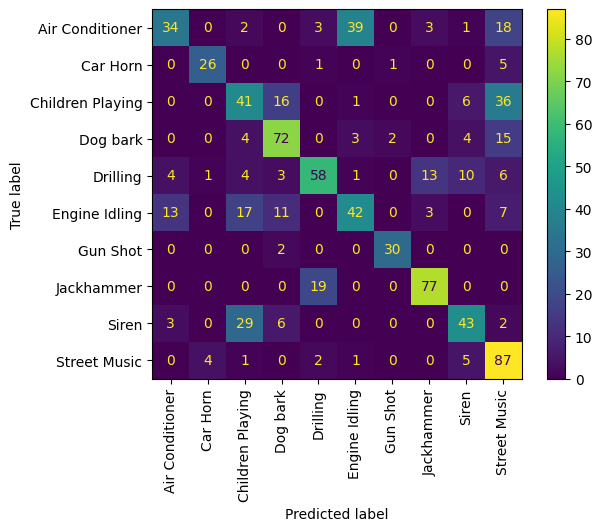

In [ ]:
dictionary = ten_fold_cross_validation(data1,'mfcc40')

In [ ]:
# mean
mean = 0
for i in range(1,11):
    name = f"acc{i}"
    mean += dictionary[name]
print(mean/11)

0.5314266139810736


#### Test Loss

In [ ]:
#test_loss
for i in range(1,11):
    name = f"loss{i}"
    print(f"test_loss{i}: ",dictionary[name])

test_loss1:  2.081064224243164
test_loss2:  1.871352195739746
test_loss3:  2.182393789291382
test_loss4:  1.6121037006378174
test_loss5:  1.8159805536270142
test_loss6:  1.7509809732437134
test_loss7:  1.551802635192871
test_loss8:  2.168881416320801
test_loss9:  1.5763126611709595
test_loss10:  1.5448859930038452


**Mean Loss:** 1.8155758142471314

#### Test Accuracy

In [ ]:
for i in range(1,11):
    name = f"acc{i}"
    print(f"test_acc{i}: ",dictionary[name])

test_acc1:  0.5349370241165161
test_acc2:  0.5281531810760498
test_acc3:  0.5264865159988403
test_acc4:  0.6232323050498962
test_acc5:  0.5844017267227173
test_acc6:  0.6099635362625122
test_acc7:  0.5894988179206848
test_acc8:  0.5644555687904358
test_acc9:  0.6752451062202454
test_acc10:  0.6093189716339111


**Mean Accuracy:** 0.5845692753791809

#### Report

In [ ]:
for i in range(1,11):
    print(f"Report{i}:")
    name = f"report{i}"
    print(dictionary[name])

Report1:
                  precision    recall  f1-score   support

 Air Conditioner       0.53      0.21      0.30       100
        Car Horn       0.58      0.83      0.68        36
Children Playing       0.85      0.28      0.42       100
        Dog bark       0.75      0.68      0.71       100
        Drilling       0.47      0.47      0.47       100
   Engine Idling       0.36      0.49      0.41        96
        Gun Shot       0.85      0.80      0.82        35
      Jackhammer       0.73      0.33      0.46       120
           Siren       0.64      0.87      0.74        86
    Street Music       0.38      0.83      0.52       100

        accuracy                           0.53       873
       macro avg       0.61      0.58      0.55       873
    weighted avg       0.60      0.53      0.52       873

Report2:
                  precision    recall  f1-score   support

 Air Conditioner       0.45      0.65      0.53       100
        Car Horn       0.79      0.26      0.39   

#### Accuracy Table

In [ ]:
for i in range(1,11):
    print(f"Accuracy_table{i}")
    name = f"confusion_matrix{i}"
    cm = dictionary[name]
    accuracies = acc_per_class(cm)
    # Display per-class accuracy in a DataFrame
    result_df = pd.DataFrame({'CLASS': labels,'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)
    print(result_df)

Accuracy_table1
              CLASS  ACCURACY
8             Siren  0.872093
1          Car Horn  0.833333
9      Street Music  0.830000
6          Gun Shot  0.800000
3          Dog bark  0.680000
5     Engine Idling  0.489583
4          Drilling  0.470000
7        Jackhammer  0.333333
2  Children Playing  0.280000
0   Air Conditioner  0.210000
Accuracy_table2
              CLASS  ACCURACY
6          Gun Shot  0.942857
9      Street Music  0.770000
3          Dog bark  0.740000
0   Air Conditioner  0.650000
8             Siren  0.593407
4          Drilling  0.500000
5     Engine Idling  0.440000
2  Children Playing  0.310000
1          Car Horn  0.261905
7        Jackhammer  0.250000
Accuracy_table3
              CLASS  ACCURACY
6          Gun Shot  0.972222
1          Car Horn  0.883721
8             Siren  0.840336
3          Dog bark  0.780000
4          Drilling  0.630000
2  Children Playing  0.610000
9      Street Music  0.480000
5     Engine Idling  0.429907
7        Jackhammer  0

#### Mean Accuracies

gun shot = 0.8851400999999999

siren = 0.7497067000000002

street music = 0.732

dog bark = 0.732

car horn = 0.6728171000000001

driling = 0.5760000000000001

children playing = 0.5098387000000001

jack hammer = 0.5062245

engine idling = 0.45328359999999995

air conditioning = 0.299

## Data Augmentation

We know that our data is imbalanced, classes Car Horn (1) and Gun Shot (6) have way fewer elements than the other classes. In this section we balance our classes by doing data augmentation and running our final model over the new dataset to check if we got better results.

In [5]:
class_counts = data['classID'].value_counts()
class_counts

2    1000
0    1000
7    1000
4    1000
5    1000
3    1000
9    1000
8     929
1     429
6     374
Name: classID, dtype: int64

The proccess of augmenting the data was described in the pre-processment notebook. We run our model with the augmented data and get the metrics in the notebook called CNN_Augmented.   

### Results

**Mean Loss:** 1.6357839107513428

**Mean Accuracy:** 0.6250869035720825

-----------------

**Mean Accuracies - Class**

Gun Shot: 0.9061772999999999

Dog Bark: 0.748

Siren: 0.7515442999999999

Street Music: 0.6559999999999999

Car Horn: 0.6530468999999999

Driling: 0.618

Children Playing: 0.5860645000000001

Jackhammer: 0.5473262999999999

Engine Idling: 0.4744815

Air Conditioner: 0.31500000000000006

### Conclusion

The data augmentation didn't have much impact on our classification, since the classes that were augmented (Car Horn and Gun Shot) kept basically the same accuracies.